<a href="https://colab.research.google.com/github/KangSeokha/DDPM/blob/main/Denoising_Diffusion_Probabilistic_Model_(DDPMs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#!pip install virtualenv

Mounted at /content/gdrive


In [ ]:
!virtualenv /content/gdrive/MyDrive/Colab\ Notebooks/colab_env
!source /content/gdrive/MyDrive/Colab\ Notebooks/colab_env/bin/activate; pip install virtualenv

/bin/bash: line 1: virtualenv: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 14.5 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.append("/content/gdrive/MyDrive/Colab\ Notebooks/colab_env/lib/python3.10/site-packages")

In [ ]:
# https://github.com/aju22/DDPM/blob/main/Denoising_Diffusion_Probabilistic_Model_(DDPMs).ipynb
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F
from torch import nn
import math

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Forward Diffusion

## ***This is the closed form equation for computing forward diffusion at any timestep.***

### *Diffusion models scale down the data with each forward process step (by a √ 1 − βt factor) so that variance does not grow when adding noise, thus providing consistently scaled inputs to the neural net reverse process.*


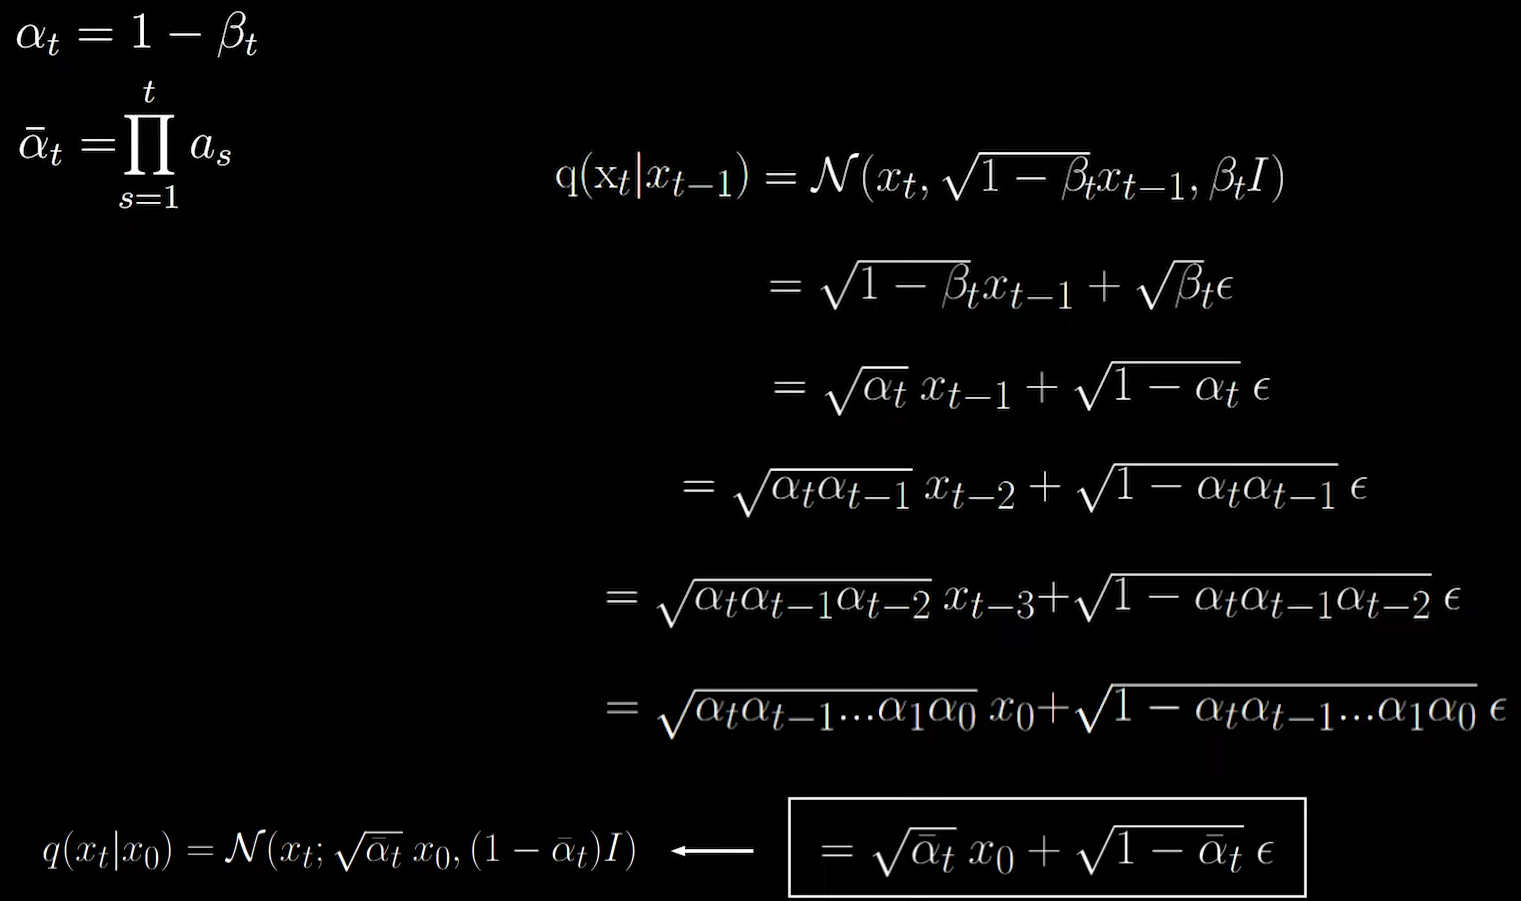

In [ ]:
def linear_scheduler(timesteps, start=0.0001, end=0.02):

    """
    Returns linear schedule for beta
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):

    """
    Returns values from vals for corresponding timesteps
    while considering the batch dimension.

    """
    print("--vals--")
    print(vals)
    print()
    print("--t--")
    print(t)
    print()
    print("--t.shape--")
    print(t.shape)
    print()
    print("--t.shape[0]-- == batch_size")
    print(t.shape[0])
    print()
    # Q1
    print("--x_shape--")
    print(x_shape)
    print()

    batch_size = t.shape[0]
    output = vals.gather(-1, t.cpu())
    print("output")
    print(output)
    print()
    print("len(x_shape)-1")
    print(len(x_shape))
    print(*((1,) * (len(x_shape) - 1)))
    print()
    print("result")
    print(output.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device))
    print()
    return output.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Takes an image and a timestep as input and
    returns the noisy version of it after adding noise t times.
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_scheduler(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
# print(sqrt_alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# U-Net Architecture

## ***U-Net Architecture is used to denoise the images and in the process learn the representations.***

![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/latent-diffusion-arch.png)

In [ ]:
# def get_loss(model, x_0, t):
#     x_noisy, noise = forward_diffusion_sample(x_0, t, device)
#     noise_pred = model(x_noisy, t)
#     return F.l1_loss(noise, noise_pred)


# def forward_diffusion_sample(x_0, t, device="cpu"):
#     """
#     Takes an image and a timestep as input and
#     returns the noisy version of it after adding noise t times.
#     """
#     noise = torch.randn_like(x_0)
#     sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
#     sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)

#     # mean + variance
#     return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# for idx in range(0, T, stepsize):
#     t = torch.Tensor([idx]).type(torch.int64)
#     print("--t--")
#     print(t)
#     print()
#     plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
#     # print(int(idx/stepsize) + 1)
#     image, noise = forward_diffusion_sample(image, t)
#     show_tensor_image(image)

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()

        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t, ):
        # Q2
        h = self.bn1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb

        h = self.bn2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeds = math.log(10000) / (half_dim - 1)
        embeds = torch.exp(torch.arange(half_dim, device=device) * -embeds)
        embeds = time[:, None] * embeds[None, :]
        embeds = torch.cat((embeds.sin(), embeds.cos()), dim=-1)
        return embeds


class Unet(nn.Module):
    """
    A simplified Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                PositionalEncoding(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )


        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([ConvBlock(down_channels[i], down_channels[i+1],
                                    time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([ConvBlock(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True) for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):

        # Embedd time
        t = self.time_mlp(timestep)
        x = self.conv0(x)

        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = Unet()
model

Unet(
  (time_mlp): Sequential(
    (0): PositionalEncoding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): ConvBlock(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(256

# Loss

## ***After some math heavy processes, we arrive at a simple loss function for training.***

![](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png)

In [ ]:
# Training
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [ ]:
# Sampling
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()

# Dataset

In [ ]:
# data = torchvision.datasets.StanfordCars(root=".", download=True)
data = torchvision.datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/car_datasets/cars_train")
# /content/gdrive/MyDrive/Colab Notebooks/archive/cars_train/cars_train

In [ ]:
def show_images(data, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

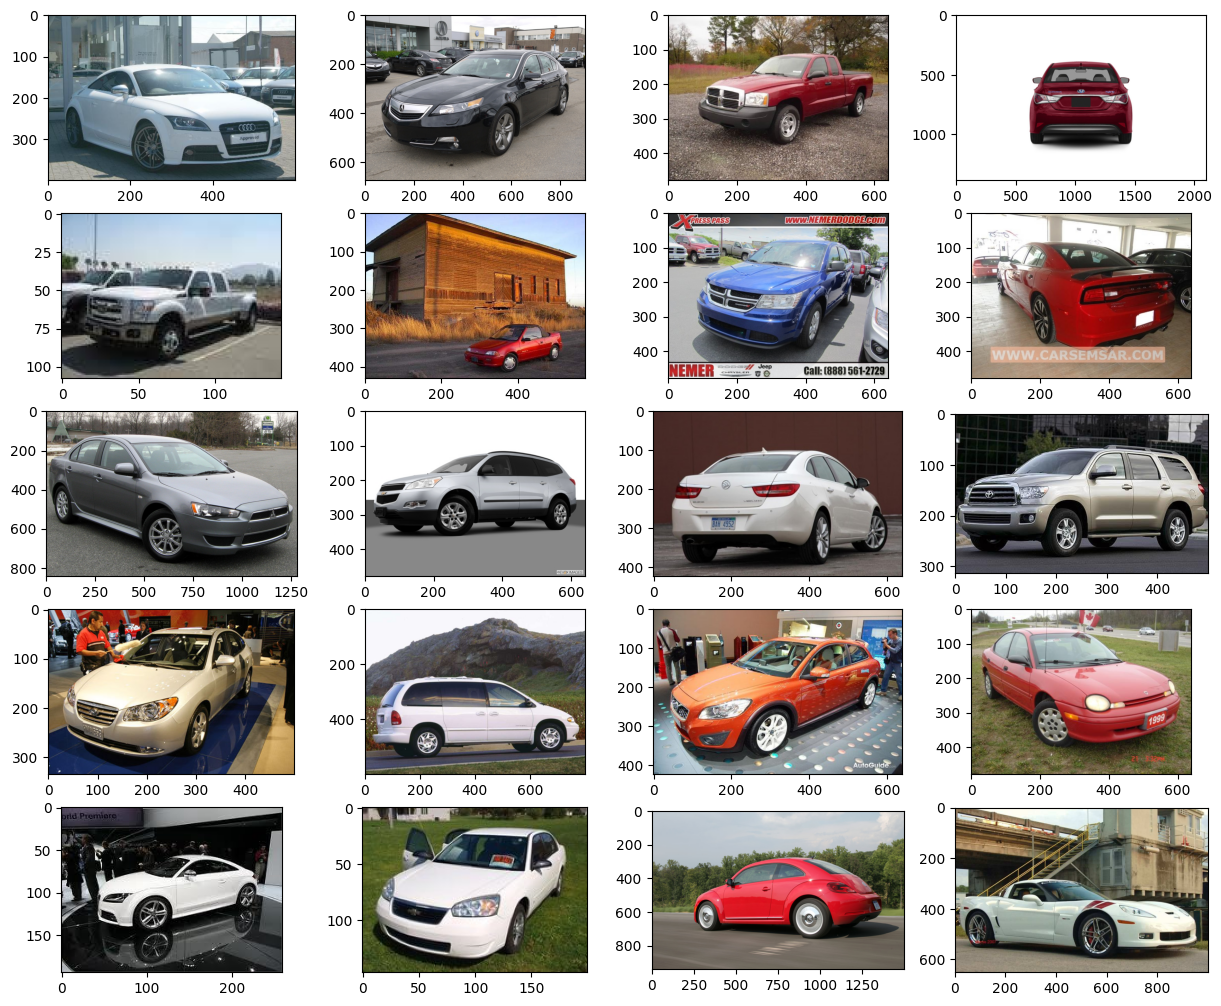

In [ ]:
show_images(data)

In [ ]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    '''
    Returns data after applying appropriate transformations,
    to work with diffusion models.
    '''
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]
    data_transform = transforms.Compose(data_transforms)

    # train = torchvision.datasets.StanfordCars(root=".", download=True, transform=data_transform)
    # test = torchvision.datasets.StanfordCars(root=".", download=True, transform=data_transform, split='test')
    train = torchvision.datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/car_datasets/cars_train", transform=data_transform)
    test  = torchvision.datasets.ImageFolder("/content/gdrive/MyDrive/Colab Notebooks/car_datasets/cars_test",  transform=data_transform)

    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    '''
    Plots image after applying reverse transformations.
    '''

    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])


    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_transformed_dataset()
print(data)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
print(dataloader)

### ***Sample Forward Diffusion***

--t--
tensor([0])

--vals--
tensor([0.9999, 0.9999, 0.9998, 0.9996, 0.9994, 0.9992, 0.9990, 0.9987, 0.9984,
        0.9980, 0.9976, 0.9972, 0.9968, 0.9963, 0.9958, 0.9952, 0.9946, 0.9940,
        0.9934, 0.9927, 0.9920, 0.9912, 0.9905, 0.9897, 0.9888, 0.9880, 0.9870,
        0.9861, 0.9851, 0.9841, 0.9831, 0.9820, 0.9809, 0.9798, 0.9787, 0.9775,
        0.9763, 0.9750, 0.9737, 0.9724, 0.9711, 0.9697, 0.9683, 0.9668, 0.9654,
        0.9639, 0.9624, 0.9608, 0.9592, 0.9576, 0.9560, 0.9543, 0.9526, 0.9509,
        0.9491, 0.9473, 0.9455, 0.9437, 0.9418, 0.9399, 0.9380, 0.9360, 0.9340,
        0.9320, 0.9300, 0.9279, 0.9258, 0.9237, 0.9216, 0.9194, 0.9172, 0.9150,
        0.9128, 0.9105, 0.9082, 0.9059, 0.9036, 0.9012, 0.8988, 0.8964, 0.8940,
        0.8915, 0.8890, 0.8865, 0.8840, 0.8815, 0.8789, 0.8763, 0.8737, 0.8711,
        0.8684, 0.8657, 0.8630, 0.8603, 0.8576, 0.8548, 0.8520, 0.8492, 0.8464,
        0.8436, 0.8407, 0.8378, 0.8350, 0.8320, 0.8291, 0.8262, 0.8232, 0.8202,
        0.81

<ipython-input-14-2a6d7b6667ee>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


--t--
tensor([90])

--vals--
tensor([0.9999, 0.9999, 0.9998, 0.9996, 0.9994, 0.9992, 0.9990, 0.9987, 0.9984,
        0.9980, 0.9976, 0.9972, 0.9968, 0.9963, 0.9958, 0.9952, 0.9946, 0.9940,
        0.9934, 0.9927, 0.9920, 0.9912, 0.9905, 0.9897, 0.9888, 0.9880, 0.9870,
        0.9861, 0.9851, 0.9841, 0.9831, 0.9820, 0.9809, 0.9798, 0.9787, 0.9775,
        0.9763, 0.9750, 0.9737, 0.9724, 0.9711, 0.9697, 0.9683, 0.9668, 0.9654,
        0.9639, 0.9624, 0.9608, 0.9592, 0.9576, 0.9560, 0.9543, 0.9526, 0.9509,
        0.9491, 0.9473, 0.9455, 0.9437, 0.9418, 0.9399, 0.9380, 0.9360, 0.9340,
        0.9320, 0.9300, 0.9279, 0.9258, 0.9237, 0.9216, 0.9194, 0.9172, 0.9150,
        0.9128, 0.9105, 0.9082, 0.9059, 0.9036, 0.9012, 0.8988, 0.8964, 0.8940,
        0.8915, 0.8890, 0.8865, 0.8840, 0.8815, 0.8789, 0.8763, 0.8737, 0.8711,
        0.8684, 0.8657, 0.8630, 0.8603, 0.8576, 0.8548, 0.8520, 0.8492, 0.8464,
        0.8436, 0.8407, 0.8378, 0.8350, 0.8320, 0.8291, 0.8262, 0.8232, 0.8202,
        0.8

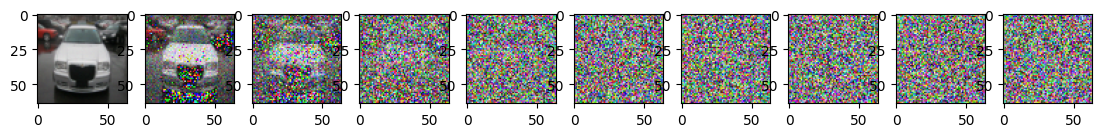

In [ ]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)
# print(stepsize)
# print(T)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    print("--t--")
    print(t)
    print()
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    # print(int(idx/stepsize) + 1)
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

### ***We can see that the noise being applied at every timestep is too aggresive and image quickly converges to pure noise.***

### ***Many researchers then used different types of beta scheduling other than the linear one we have used, like for example a cosine schedule which adds noise more gradually.***

# Training

In [ ]:
from torch.optim import Adam

Streaming output truncated to the last 5000 lines.
        5.1729e-03, 5.2398e-03, 5.3067e-03, 5.3735e-03, 5.4404e-03, 5.5073e-03,
        5.5742e-03, 5.6411e-03, 5.7079e-03, 5.7748e-03, 5.8417e-03, 5.9086e-03,
        5.9755e-03, 6.0424e-03, 6.1093e-03, 6.1763e-03, 6.2432e-03, 6.3101e-03,
        6.3770e-03, 6.4439e-03, 6.5109e-03, 6.5778e-03, 6.6447e-03, 6.7117e-03,
        6.7786e-03, 6.8456e-03, 6.9125e-03, 6.9795e-03, 7.0464e-03, 7.1134e-03,
        7.1804e-03, 7.2473e-03, 7.3143e-03, 7.3813e-03, 7.4482e-03, 7.5152e-03,
        7.5822e-03, 7.6492e-03, 7.7162e-03, 7.7831e-03, 7.8501e-03, 7.9171e-03,
        7.9841e-03, 8.0511e-03, 8.1181e-03, 8.1851e-03, 8.2521e-03, 8.3191e-03,
        8.3861e-03, 8.4532e-03, 8.5202e-03, 8.5872e-03, 8.6542e-03, 8.7212e-03,
        8.7882e-03, 8.8553e-03, 8.9223e-03, 8.9893e-03, 9.0564e-03, 9.1234e-03,
        9.1904e-03, 9.2575e-03, 9.3245e-03, 9.3915e-03, 9.4586e-03, 9.5256e-03,
        9.5927e-03, 9.6597e-03, 9.7268e-03, 9.7938e-03, 9.8609e-03, 9

<ipython-input-9-2d35b14f727f>:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


Streaming output truncated to the last 5000 lines.
        6.0900e-03, 6.1565e-03, 6.2231e-03, 6.2896e-03, 6.3562e-03, 6.4227e-03,
        6.4893e-03, 6.5559e-03, 6.6224e-03, 6.6890e-03, 6.7555e-03, 6.8221e-03,
        6.8886e-03, 6.9552e-03, 7.0217e-03, 7.0883e-03, 7.1548e-03, 7.2214e-03,
        7.2880e-03, 7.3545e-03, 7.4211e-03, 7.4876e-03, 7.5542e-03, 7.6207e-03,
        7.6873e-03, 7.7538e-03, 7.8204e-03, 7.8870e-03, 7.9535e-03, 8.0201e-03,
        8.0866e-03, 8.1532e-03, 8.2197e-03, 8.2863e-03, 8.3528e-03, 8.4194e-03,
        8.4860e-03, 8.5525e-03, 8.6191e-03, 8.6856e-03, 8.7522e-03, 8.8187e-03,
        8.8853e-03, 8.9518e-03, 9.0184e-03, 9.0850e-03, 9.1515e-03, 9.2181e-03,
        9.2846e-03, 9.3512e-03, 9.4177e-03, 9.4843e-03, 9.5508e-03, 9.6174e-03,
        9.6839e-03, 9.7505e-03, 9.8171e-03, 9.8836e-03, 9.9502e-03, 1.0017e-02,
        1.0083e-02, 1.0150e-02, 1.0216e-02, 1.0283e-02, 1.0349e-02, 1.0416e-02,
        1.0483e-02, 1.0549e-02, 1.0616e-02, 1.0682e-02, 1.0749e-02, 1

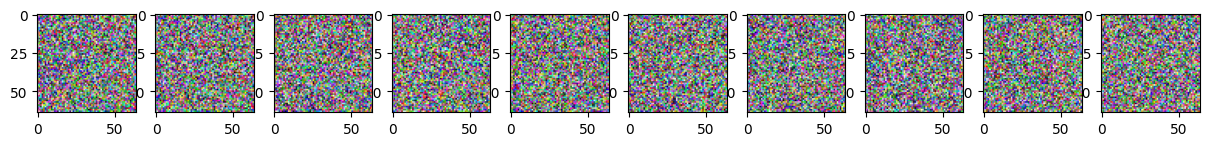

Streaming output truncated to the last 5000 lines.
        [[[0.3362]]],


        [[[0.9538]]],


        [[[0.9191]]],


        [[[0.4770]]],


        [[[0.8744]]],


        [[[0.9064]]],


        [[[0.5144]]],


        [[[0.9384]]],


        [[[0.4235]]],


        [[[0.6999]]],


        [[[0.9609]]],


        [[[0.2608]]],


        [[[0.2663]]],


        [[[0.6894]]],


        [[[0.9293]]],


        [[[0.7977]]],


        [[[0.0516]]],


        [[[0.0163]]],


        [[[0.6452]]],


        [[[0.9456]]],


        [[[0.8416]]],


        [[[0.1434]]],


        [[[0.1034]]],


        [[[0.5190]]],


        [[[0.3467]]],


        [[[0.9416]]],


        [[[0.9624]]],


        [[[0.9736]]],


        [[[0.5144]]],


        [[[0.1034]]],


        [[[0.9494]]],


        [[[0.9191]]],


        [[[0.8587]]],


        [[[0.9702]]],


        [[[0.9484]]],


        [[[0.6490]]],


        [[[0.8744]]],


        [[[0.7923]]],


        [[[0.1943]]],


        [[[0.

In [ ]:
model.to(device)
optimizer = Adam(model.parameters(), lr=3e-4)
epochs = 100
print(dataloader)
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
      loss = get_loss(model, batch[0], t)
      loss.backward()
      optimizer.step()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
        sample_plot_image()